**Lab** 3 (Time Series Analysis)

I have data on Google search for sunburn and average monthly temperatures for Texas from 2004-2024.  I would think that as average temperatures rise (though they may not be rising much), there would be more searches for "sunburn."  Let's see.  I start by loading in the data.

In [ ]:
# Step 1: Load and preprocess the dataset

# from meta
from google.colab import files
uploaded = files.upload()

import pandas as pd
import io

# Get the original file name from the uploaded dictionary
filename = list(uploaded.keys())[0]

# Read the uploaded file
data = pd.read_csv(io.BytesIO(uploaded[filename]))

# Display the first few rows of the dataframe
data.head()

Saving Merged_Sunscreen_and_Temperature_Data.csv to Merged_Sunscreen_and_Temperature_Data (7).csv


,Unnamed: 0,Period,Average Temperature,Month,Search Volume
0,0,200401,48.9,2004-01-01,0
1,1,200402,47.4,2004-02-01,0
2,2,200403,61.8,2004-03-01,0
3,3,200404,64.3,2004-04-01,15
4,4,200405,73.7,2004-05-01,36


**Step 1- Create a multivariate time series; perform any interpolations.**

I need the dataset to contain variables representing renamed variables on temperature, search volume, and then to create dummies for monthly periods.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Convert 'Month' to a datetime object and set as index
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

# Interpolate missing values
data_interpolated = data.interpolate(method='linear')

# Rename columns to simplify usage
data_interpolated.rename(columns={"Search Volume": "SearchVolume", "Average Temperature": "AvgTemperature"}, inplace=True)

# Create monthly dummies
data_interpolated['Month_Num'] = data_interpolated.index.month
monthly_dummies = pd.get_dummies(data_interpolated['Month_Num'], prefix='Month', drop_first=True)
data_interpolated = pd.concat([data_interpolated, monthly_dummies], axis=1)

Next, we visualize the relationship between average temperature and search volume, first over time.  This provides an intuitive understanding of how these variables vary together. The graphs reveal a seasonal pattern in both temperature and search volume, suggesting a potential correlation that warrants further exploration.


**Step 2- Graph the relationships between X and Y. Explain how you think Y should relate to your key Xs.**

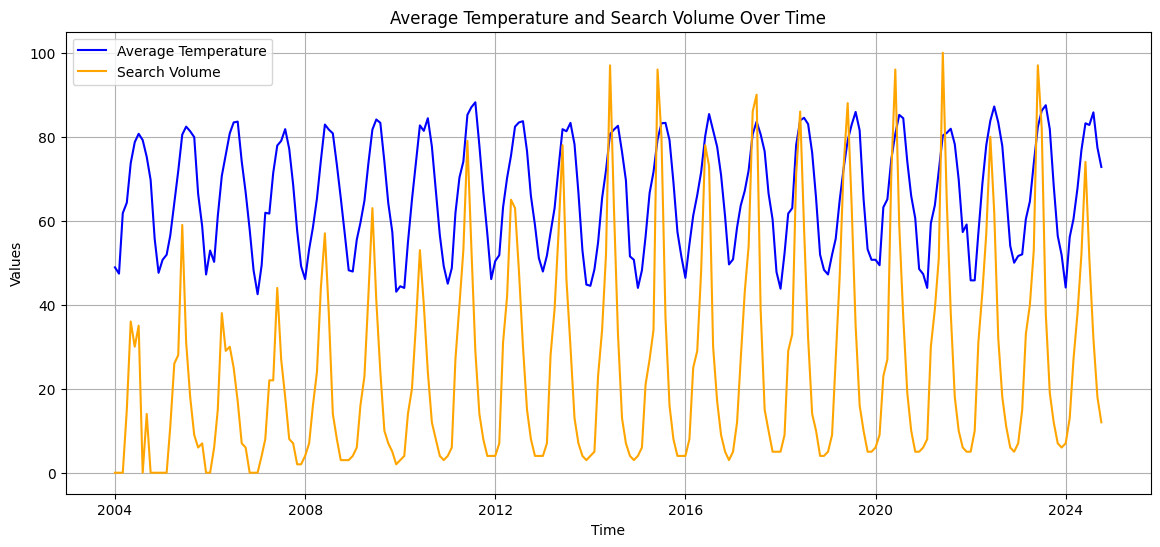

In [ ]:
# Step 2: Graph the relationships
plt.figure(figsize=(14, 6))
plt.plot(data_interpolated.index, data_interpolated['AvgTemperature'], label='Average Temperature', color='blue')
plt.plot(data_interpolated.index, data_interpolated['SearchVolume'], label='Search Volume', color='orange')
plt.title('Average Temperature and Search Volume Over Time')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()







We see that the scatter suggests a positive corration.

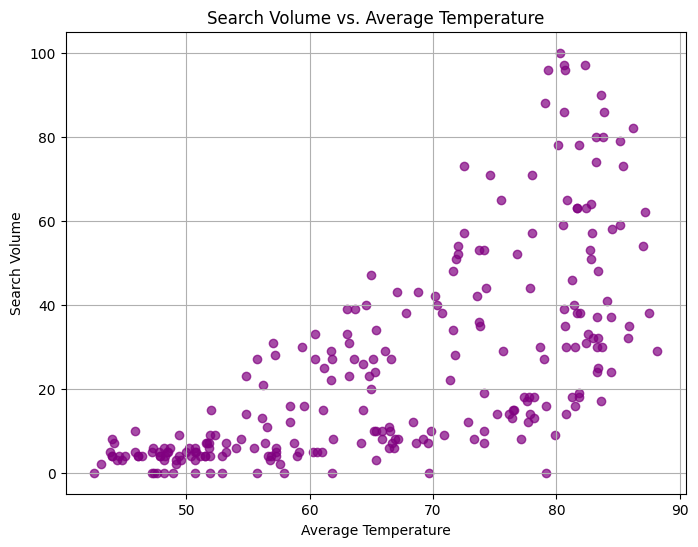

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(data_interpolated['AvgTemperature'], data_interpolated['SearchVolume'], color='purple', alpha=0.7)
plt.title('Search Volume vs. Average Temperature')
plt.xlabel('Average Temperature')
plt.ylabel('Search Volume')
plt.grid(True)
plt.show()

**Step 3- Run a simple time series regression, with one X and no trend. Interpret it.**

We will run a "naive" model predicting search as a function of temperature, and we see, as we did in the scatterplot, that the results show a significant positive relationship, with temperature explaining about 46% of the variability in search volume.

In [ ]:
# Step 3: Regression with Only Average Temperature Predicting Search Volume
model_temp_only = ols('SearchVolume ~ AvgTemperature', data=data_interpolated).fit()
print(model_temp_only.summary())


                            OLS Regression Results                            
Dep. Variable:           SearchVolume   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     214.2
Date:                Thu, 21 Nov 2024   Prob (F-statistic):           2.19e-35
Time:                        17:56:43   Log-Likelihood:                -1075.4
No. Observations:                 250   AIC:                             2155.
Df Residuals:                     248   BIC:                             2162.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -58.3369      5.813    -10.

**Step 4- Run a time series regression with one X and trend. Interpret it. Perform autocorrelation diagnostics. Explain what you found.**

We know that usually, it is too simple to just correlate two time series variables together, so we must do more.  Adding a trend and monthly dummies in the fourth step accounts for time effects and seasonality, providing a more nuanced model. This allows us to separate the impact of temperature from broader temporal patterns. The findings indicate that both trend and certain months significantly affect search volume, suggesting seasonality and gradual increases over time.  The Durbin-Watson statistic is pretty far from 2, suggesting maybe still some autocorrelation.


In [ ]:


# Step 4: Add trend and monthly dummies
data_interpolated['Trend'] = np.arange(1, len(data_interpolated) + 1)
model_with_trend = ols('SearchVolume ~ AvgTemperature + Trend + ' + ' + '.join(monthly_dummies.columns),
                       data=data_interpolated).fit()
print(model_with_trend.summary())



                            OLS Regression Results                            
Dep. Variable:           SearchVolume   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     146.3
Date:                Thu, 21 Nov 2024   Prob (F-statistic):          6.14e-105
Time:                        17:56:45   Log-Likelihood:                -877.73
No. Observations:                 250   AIC:                             1783.
Df Residuals:                     236   BIC:                             1833.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -26.0504      9.943  

**Step 5- Consider running a time series regression with many Xs and trend. Interpret that. Check VIF.**

To address multicollinearity, we calculate the Variance Inflation Factor (VIF) for the predictors in the fifth step. This ensures that our regression estimates are not distorted by highly correlated variables. The analysis reveals moderate multicollinearity for temperature and trend.

In [ ]:
# Step 5: Variance Inflation Factors
# Ensure predictors are numeric and contain no missing values
predictors_cleaned = predictors.select_dtypes(include=[np.number]).dropna()

# Recalculate VIF
vif_data = pd.DataFrame()
vif_data['Variable'] = predictors_cleaned.columns
vif_data['VIF'] = [variance_inflation_factor(predictors_cleaned.values, i) for i in range(predictors_cleaned.shape[1])]

# Display the VIF results
print(vif_data)



         Variable       VIF
0  AvgTemperature  3.742824
1           Trend  3.742824


**Step 6- Run a first differenced time series regression. Interpret that.**

In the sixth step, we perform a first-differenced regression with "change in month" dummies to focus on short-term changes and seasonal transitions. This step removes trends and isolates month-to-month shifts in search volume. The results highlight that temperature changes and transitions between certain months have significant impacts on search behavior. Average temperature is still a powerful predictor! Durbin-Watson statistic is near to 2, indicating not much autocorrelation concern.

In [ ]:
# Step 6: Updated First-Differenced Model with "Change in Month" Dummies
data_interpolated['Diff_SearchVolume'] = data_interpolated['SearchVolume'].diff()
data_interpolated['Diff_AvgTemperature'] = data_interpolated['AvgTemperature'].diff()
change_in_month_dummies = monthly_dummies.diff().iloc[1:]
data_with_differences = pd.concat([data_interpolated[['Diff_SearchVolume', 'Diff_AvgTemperature']], change_in_month_dummies], axis=1).dropna()
model_diff_with_change_dummies = ols('Diff_SearchVolume ~ Diff_AvgTemperature + ' +
                                     ' + '.join(change_in_month_dummies.columns),
                                     data=data_with_differences).fit()
print(model_diff_with_change_dummies.summary())



                            OLS Regression Results                            
Dep. Variable:      Diff_SearchVolume   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     67.84
Date:                Thu, 21 Nov 2024   Prob (F-statistic):           7.94e-67
Time:                        17:56:52   Log-Likelihood:                -875.99
No. Observations:                 249   AIC:                             1776.
Df Residuals:                     237   BIC:                             1818.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0703    

**Step 7- Check your variables for unit roots. Do some tests. Interpret them.**

The seventh step applies the KPSS test to assess the stationarity of the original and differenced series for Search Volume, for instance. This ensures the data meets the assumptions required for time series modeling.

In [ ]:
# Step 7: KPSS Test for Stationarity
def kpss_test(series):
    statistic, p_value, _, critical_values = kpss(series, regression='c')
    return {'KPSS Statistic': statistic, 'p-value': p_value, 'Critical Values': critical_values}

kpss_original = kpss_test(data_interpolated['SearchVolume'].dropna())
kpss_diff = kpss_test(data_interpolated['Diff_SearchVolume'].dropna())
print("KPSS Test Results (Original):", kpss_original)
print("KPSS Test Results (Differenced):", kpss_diff)



KPSS Test Results (Original): {'KPSS Statistic': 0.8425548381883201, 'p-value': 0.01, 'Critical Values': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}}
KPSS Test Results (Differenced): {'KPSS Statistic': 0.010115707600376209, 'p-value': 0.1, 'Critical Values': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}}


<ipython-input-23-ae4526143883>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, _, critical_values = kpss(series, regression='c')
<ipython-input-23-ae4526143883>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, _, critical_values = kpss(series, regression='c')


The test confirms the original series is non-stationary (p<0.05), but differencing successfully achieves stationarity (p>.05).

**Step 8 (not done.  That's ok!)-Perform an Automatic ARIMA on the residuals from one of your earlier models. Tell me what it says.**

**Step 9- Run an ARIMA that follows from Step 8. Interpret that, too.**

Since I did not run an auto.arima over my residuals, my pick for ARIMA is a bit arbitrary.  Nonetheless, I picked an ARIMA(1,1,1) with seasonal adjustment for 12 months.

In [ ]:
# Step 8: ARIMA(1,1,1) Model with "Change in Month" Dummies
# Ensure SearchVolume and dummies are numeric and clean
search_volume_cleaned = pd.to_numeric(data_interpolated['SearchVolume'], errors='coerce').dropna()
dummies_only_cleaned = monthly_dummies.diff().apply(pd.to_numeric, errors='coerce').dropna()

# Align indices to avoid mismatches
aligned_index = search_volume_cleaned.index.intersection(dummies_only_cleaned.index)
search_volume_cleaned = search_volume_cleaned.loc[aligned_index]
dummies_only_cleaned = dummies_only_cleaned.loc[aligned_index]



This SARIMAX model indicates that the non-seasonal AR(1) and MA(1) terms are significant, showing short-term temporal dependencies in the data, while the seasonal MA(12) term is also significant, capturing monthly seasonality. The overall model fits the data well (AIC = 1607.696), and the residual diagnostics suggest that our residuals achieved white noise.


In [ ]:
# Ensure SearchVolume is numeric and clean
search_volume_cleaned = pd.to_numeric(data_interpolated['SearchVolume'], errors='coerce').dropna()

# Fit SARIMAX with 12 seasonal periods (seasonal_order=(1, 1, 1, 12))
sarimax_model = ARIMA(
    search_volume_cleaned,
    order=(1, 1, 1),  # ARIMA order
    seasonal_order=(1, 1, 1, 12)  # SARIMA seasonal order (P, D, Q, s)
).fit()

# Display the summary
print(sarimax_model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:                     SearchVolume   No. Observations:                  250
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -798.848
Date:                          Thu, 21 Nov 2024   AIC                           1607.696
Time:                                  17:59:57   BIC                           1625.037
Sample:                              01-01-2004   HQIC                          1614.686
                                   - 10-01-2024                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2888      0.054      5.351      0.000       0.183       0.395
ma.L1         -0.9760      0.027    -35.564      0.